## Bach 

### created by Yuying Liu, 06/08/2020

This script is used to do sequence generation on a music excerpt from Bach’s Fugue No. 1 In C Major, BWV 846, which  can be used to reproduce a row in Figure 7.

In [1]:
# imports
import os
import sys
import torch
import numpy as np
import scipy as sp
# import librosa
# import librosa.display
import IPython.display as ipd
from tqdm.notebook import tqdm
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

'1.24.4'

In [2]:
# # # # # # # # # # # # # # # # # #
#  global constants, paths, etc.  #
# # # # # # # # # # # # # # # # # #
data_dir = '../../data/Bach/'
result_dir = '../../results/Bach/'

## Part I

### process data

In [5]:
# read the raw data
init = 33750
period = 2
gap = 20
# wav, sr = librosa.load(os.path.join(data_dir, 'C_major.wav'))
# wav, sr = librosa.load('C_major.wav')

# sig = wav[init:init+period*sr]
# sampled_sig = sig[::gap]
sampled_sig = np.load('sample_saved.npy')

In [ ]:
# # viz the spectrum
# X = librosa.stft(sig)
# Xdb = librosa.amplitude_to_db(abs(X))
# plt.figure(figsize=(16, 4))
# librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [6]:
# # plot the audio
# plt.figure(figsize=(32, 2))
# plt.plot(np.linspace(0, period, sampled_sig.shape[0]), sampled_sig)
# plt.tick_params(axis="x", labelsize=30)
# plt.tick_params(axis="y", labelsize=30)

In [7]:
# play the original audio
# ipd.Audio(sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_truth.wav'), sig, sr)

In [18]:
# time-delay embedding
data_embed = np.zeros((128, sampled_sig.shape[0]-128))
for i in range(128):
    data_embed[i, :] = sampled_sig[i:-128+i]
# np.save(os.path.join(data_dir, 'data.npy'), data_embed)   # <-- this is the data set for training NNs
# print(data.shape)

In [10]:
# trim the last
sampled_sig = sampled_sig[:-1]

In [19]:
data_embed.shape

(128, 2076)

In [20]:
data = data_embed.T
n_steps = 2076
step_size = 25
n_forward = 3
m = int(np.ceil(n_steps/(71)*3))
pdata = np.zeros((m, step_size*n_forward+1, data.shape[1]))
for i in range(m):
    start_idx = i*int(step_size*n_forward/3)
    end_idx = start_idx + step_size*n_forward + 1
    tmp = data[start_idx:end_idx, :]
    pdata[i, :tmp.shape[0], :] = tmp
    
print(pdata.shape)

(88, 76, 128)


In [21]:
data.shape

(2076, 128)

In [22]:
np.save(os.path.join(data_dir, 'train_noise0.0.npy'), pdata) 
np.save(os.path.join(data_dir, 'test_noise0.0.npy'), data.reshape(1, 2076, 128)) 

### sampled signal

In [11]:
sampled_timesteps = np.linspace(0, period, len(sampled_sig))
timesteps = np.linspace(0, period, (len(sampled_sig)-1)*gap+1)

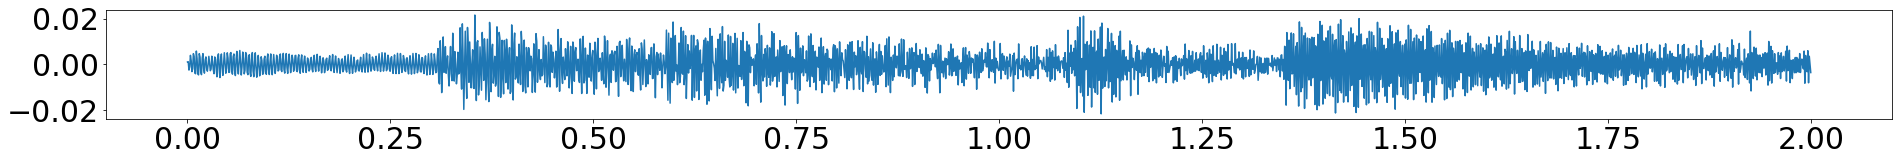

In [12]:
# plot the interpolated audio
plt.figure(figsize=(32, 2))
plt.plot(sampled_timesteps, sampled_sig)
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)

([], [])

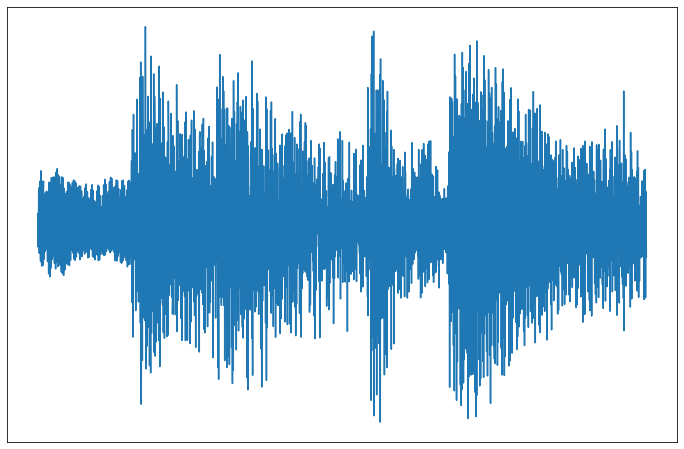

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(sampled_timesteps, sampled_sig)
plt.xticks([])
plt.yticks([])

In [14]:
# play the interpolated audio
tck = interpolate.splrep(sampled_timesteps, sampled_sig)
interp_sig = interpolate.splev(timesteps, tck)
ipd.Audio(interp_sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_reduced_truth.wav'), interp_sig, sr)

NameError: name 'sr' is not defined

## Part II

<font color='red'>Attention: use seq_generations.ipynb to train differen architectures and generate target sequences before running part II. The code below requires numpy files Bach_{model}_pred.npy. </font>

### coupled NNs

In [ ]:
# coupled NN reconstruction
file_data = np.load(os.path.join(result_dir, 'Bach_couple_pred.npy'))
coupled_sig = np.zeros(sampled_sig.shape)
coupled_sig[:file_data.shape[0]] = file_data[:, 0]
coupled_sig[file_data.shape[0]:] = file_data[-1, 1:]

print(((coupled_sig - sampled_sig)**2).mean())
plt.figure(figsize=(32, 2))
plt.plot(sampled_timesteps, coupled_sig)
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sampled_timesteps, coupled_sig)
plt.xticks([])
plt.yticks([])
plt.ylim([-0.025, 0.025])

In [ ]:
# play the interpolated audio from coupled nn
coupled_tck = interpolate.splrep(sampled_timesteps, coupled_sig)
interp_coupled_sig = interpolate.splev(timesteps, coupled_tck)
ipd.Audio(interp_coupled_sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_HiTS_pred.wav'), interp_coupled_sig, sr)

### lstm

In [ ]:
# lstm reconstruction
file_data = np.load(os.path.join(result_dir, 'Bach_lstm_pred.npy'))
lstm_sig = np.zeros(sampled_sig.shape)
lstm_sig[:file_data.shape[0]] = file_data[:, 0]
lstm_sig[file_data.shape[0]:] = file_data[-1, 1:]

print(((lstm_sig - sampled_sig)**2).mean())
plt.figure(figsize=(32, 2))
plt.plot(sampled_timesteps, lstm_sig)
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sampled_timesteps, lstm_sig)
plt.xticks([])
plt.yticks([])
plt.ylim([-0.025, 0.025])

In [ ]:
# play the interpolated audio from coupled nn
lstm_tck = interpolate.splrep(sampled_timesteps, lstm_sig)
interp_lstm_sig = interpolate.splev(timesteps, lstm_tck)
ipd.Audio(interp_lstm_sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_LSTM_pred.wav'), interp_lstm_sig, sr)

### reservoir computing

In [ ]:
# esn reconstruction
file_data = np.load(os.path.join(result_dir, 'Bach_reservoir_pred.npy'))
reservoir_sig = np.zeros(sampled_sig.shape)
reservoir_sig[:file_data.shape[0]] = file_data[:, 0]
reservoir_sig[file_data.shape[0]:] = file_data[-1, 1:]

print(((reservoir_sig - sampled_sig)**2).mean())
plt.figure(figsize=(32, 2))
plt.plot(sampled_timesteps, reservoir_sig)
plt.ylim([-0.025, 0.025])
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sampled_timesteps, reservoir_sig)
plt.xticks([])
plt.yticks([])
plt.ylim([-0.02, 0.02])

In [ ]:
# play the interpolated audio from coupled nn
reservoir_tck = interpolate.splrep(sampled_timesteps, reservoir_sig)
interp_reservoir_sig = interpolate.splev(timesteps, reservoir_tck)
ipd.Audio(interp_reservoir_sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_Reservoir_pred.wav'), interp_reservoir_sig, sr)

### cwrnn

In [ ]:
# cwrnn reconstruction
file_data = np.load(os.path.join(result_dir, 'Bach_cwrnn_pred.npy'))
cwrnn_sig = np.zeros(sampled_sig.shape)
cwrnn_sig[:file_data.shape[0]] = file_data[:, 0]
cwrnn_sig[file_data.shape[0]:] = file_data[-1, 1:]

print(((cwrnn_sig - sampled_sig)**2).mean())
plt.figure(figsize=(32, 2))
plt.plot(sampled_timesteps, cwrnn_sig)
plt.tick_params(axis="x", labelsize=30)
plt.tick_params(axis="y", labelsize=30)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(sampled_timesteps, cwrnn_sig)
plt.xticks([])
plt.yticks([])
plt.ylim([-0.02, 0.02])

In [ ]:
# play the interpolated audio from coupled nn
cwrnn_tck = interpolate.splrep(sampled_timesteps, cwrnn_sig)
interp_cwrnn_sig = interpolate.splev(timesteps, cwrnn_tck)
ipd.Audio(interp_cwrnn_sig, rate=sr)
# librosa.output.write_wav(os.path.join(result_dir, 'Bach_CWRNN_pred.wav'), interp_cwrnn_sig, sr)